# Qwen3 Tuning
for ARC AGI 2

Updates 22 July 2025:
- Increased lora r to 256
- Added training on completions only
- Moved to cosine rather than constant scheduler. Moved from 1 to 2 epochs. Note that SOAR use 3 epochs with cosine scheduler.

### Installation

In [1]:
%%capture
import os
!pip install uv -qU
!uv pip install unsloth matplotlib -qU --system

In [2]:
from huggingface_hub import HfFolder, login

# Call this at the top of your script / notebook
if HfFolder.get_token() is None:   # no token cached or in $HF_TOKEN
    login()                        # interactive prompt

In [3]:
!uv pip install --system tensorboard -qU
%load_ext tensorboard
%tensorboard --logdir ./logs --port 6006 --bind_all

### Unsloth

In [4]:
from unsloth import FastLanguageModel
import torch, os

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen3-4B",
    # model_name = "Qwen/Qwen3-30B-A3B",
    max_seq_length = 32000,   # Context length - can be longer, but uses more memory
    load_in_4bit = False,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    cache_dir = '',
    # token = "hf_...",      # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.7: Fast Qwen3 patching. Transformers: 4.53.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.209 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# print(model)

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [6]:


model = FastLanguageModel.get_peft_model(
    model,
    r = 256,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128. could consider 128.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",
                     ],
    lora_alpha = 32,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.7.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


<a name="Data"></a>
### Data Prep

In [7]:
from pathlib import Path
import json
from datasets import load_dataset, DatasetDict

# train_path   = Path("gemini_synth_1_train.jsonl") # clean code
train_path   = Path("gemini_synth_10_train.jsonl") # clean code
# train_path   = Path("gemini_2_5_flash_training_data_clean_code_reasoning.jsonl") # clean code with reasoning
val_path     = Path("gemini_synth_10_shortest_training_10.jsonl")

def jsonl_to_dataset(path: Path):
    """
    Read a .jsonl file whose lines look like:
      {"messages": [{"role": "...", "content": "..."}, ...]}
    and convert each example to {'text': <template-rendered string>}.
    """
    # fast path via 🤗 Datasets – streams file → maps in C++
    ds = load_dataset(
        "json",
        data_files=str(path),
        split="train",           # a single split, we'll rename later
        keep_in_memory=True,
    )
    # apply chat template and drop original columns
    ds = ds.map(
        lambda ex: {
            "text": tokenizer.apply_chat_template(
                ex["messages"],
                tokenize=False,              # keep raw text
                add_generation_prompt=False  # set True if you need the assistant tag
            )
        },
        remove_columns=ds.column_names,
    )
    return ds

data = DatasetDict(
    train=jsonl_to_dataset(train_path),
    validation=jsonl_to_dataset(val_path),
)

data

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 60
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 9
    })
})

In [8]:
print(data["train"][0])

{'text': "<|im_start|>system\nYou are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code.<|im_end|>\n<|im_start|>user\nYou are solving an ARC (Abstraction and Reasoning Corpus) task. \nI will show you training examples with input and output grids, plus a test input grid. Your task is to:\n\n1. **Analyze the training examples** to discover patterns that map input grids to output grids\n2. **Write a Python program** that implements your best understanding of the transformation  \n3. **DO NOT predict or generate the test output** - your job is only to write the transformation program\n4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis\n5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.\n\n**IMPORTANT: Your transformation must always produce a 10×10 output grid.**\n\nThe test input is shown for context so you understand what type of grid your program 

Let's see the structure of both datasets:

In [9]:
import numpy as np
from statistics import median

def length_stats(dataset, name=""):
    """
    Return min / median / max tokenised length for a 🤗 Dataset split that has a
    single 'text' column. Uses the same tokenizer already in memory.
    """
    # Tokenise in batches → list of list[int] → list[int] lengths
    lengths = dataset.map(
        lambda batch: {
            "len": [len(ids) for ids in tokenizer(batch["text"],
                                                  add_special_tokens=False
                                                 )["input_ids"]]
        },
        batched=True,
        remove_columns=dataset.column_names,   # drop 'text'
        keep_in_memory=True,
    )["len"]

    print(f"{name:>11}:  min={min(lengths):>4}  "
          f"median={int(median(lengths)):>4}  max={max(lengths):>4}")

# ── run for both splits ────────────────────────────────────────────────────────
length_stats(data["train"],       "train")
length_stats(data["validation"],  "validation")


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

      train:  min=2048  median=2395  max=2834


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

 validation:  min= 723  median= 764  max= 858


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [10]:
run_name="qwen_gemini_synth_10-23jul" # MODEL NAME MUST INCLUDE QWEN FOR INFERENCE SCRIPTS TO WORK!
# run_name="qwen_gemini_synth_1-23jul" # MODEL NAME MUST INCLUDE QWEN FOR INFERENCE SCRIPTS TO WORK!

from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = data["train"],
    eval_dataset = data["validation"], # Can set up evaluation!
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 1, # Use GA to mimic batch size!
        warmup_steps = 5,
        eval_steps = 0.1,
        do_eval = True,
        eval_strategy = "steps",
        num_train_epochs = 3, # Set this for 1 full training run.
        # max_steps = 10,
        learning_rate = 1e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 0.05,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        report_to = "tensorboard", # Use this for WandB etc
        logging_dir=f"./logs/{run_name}",
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/60 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/9 [00:00<?, ? examples/s]

In [11]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA H100 80GB HBM3. Max memory = 79.209 GB.
9.506 GB of memory reserved.


In [12]:
from unsloth.chat_templates import train_on_responses_only # or run the code above if not using unsloth

TEMPLATES = {
    "llama": (
        "<|start_header_id|>user<|end_header_id|>\n\n",
        "<|start_header_id|>assistant<|end_header_id|>\n\n",
    ),
    "gemma": (
        "<start_of_turn>user\n",
        "<start_of_turn>model\n",
    ),
    "qwen": (
        "<|im_start|>user\n",
        "<|im_start|>assistant\n<think>\n\n</think>\n\n", # this is actually how you properly allow the model to keep reasoning!
    ),
    "mistral": (
        "[INST]",
        "[/INST]",
    )
}

instruction_tag, response_tag = TEMPLATES["qwen"]   # ← change if needed

# masks everything between the instruction_part and response_part
trainer = train_on_responses_only(
    trainer,
    instruction_part = instruction_tag,
    response_part = response_tag,
    # force_match=False # comment out to set true for a cleaner masking
)

num_proc must be <= 60. Reducing num_proc to 60 for dataset of size 60.


Map (num_proc=60):   0%|          | 0/60 [00:00<?, ? examples/s]

num_proc must be <= 9. Reducing num_proc to 9 for dataset of size 9.


Map (num_proc=9):   0%|          | 0/9 [00:00<?, ? examples/s]

In [13]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

"<|im_start|>system\nYou are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code.<|im_end|>\n<|im_start|>user\nYou are solving an ARC (Abstraction and Reasoning Corpus) task. \nI will show you training examples with input and output grids, plus a test input grid. Your task is to:\n\n1. **Analyze the training examples** to discover patterns that map input grids to output grids\n2. **Write a Python program** that implements your best understanding of the transformation  \n3. **DO NOT predict or generate the test output** - your job is only to write the transformation program\n4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis\n5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.\n\n**IMPORTANT: Your transformation must always produce a 10×10 output grid.**\n\nThe test input is shown for context so you understand what type of grid your program will even

In [14]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, " ")

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [15]:
# We should consider training on completions only!!! which means the response part for the xentropy.

In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 60 | Num Epochs = 3 | Total steps = 12
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 528,482,304 of 4,550,950,400 (11.61% trained)


Step,Training Loss,Validation Loss
2,1.056900,0.774284
4,0.397200,0.363959
6,0.298000,0.334183
8,0.242700,0.367940
10,0.218900,0.377569
12,0.198000,0.377700


Unsloth: Will smartly offload gradients to save VRAM!


In [17]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

39.9028 seconds used for training.
0.67 minutes used for training.
Peak reserved memory = 22.949 GB.
Peak reserved memory for training = 13.443 GB.
Peak reserved memory % of max memory = 28.973 %.
Peak reserved memory for training % of max memory = 16.972 %.


<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [18]:
# messages = [
#     {"role" : "system", "content" : "You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code."},
#     {"role" : "user", "content" : "You are solving an ARC (Abstraction and Reasoning Corpus) task. I will show you training examples with input and output grids, plus a test input grid. Your task is to: 1. **Analyze the training examples** to discover patterns that map input grids to output grids 2. **Write a Python program** that implements your best understanding of the transformation 3. **DO NOT predict or generate the test output** - your job is only to write the transformation program 4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis 5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it. **IMPORTANT: Your transformation must always produce a 3×3 output grid.** The test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from training examples and writing code that captures your understanding. Training Examples: Example 1: Input: 6 6 6 7 7 7 0 0 6 0 0 6 0 0 6 6 0 0 6 6 0 0 0 0 6 0 0 0 7 0 0 7 0 0 6 7 6 0 7 0 6 0 0 7 6 0 0 0 0 7 0 0 6 6 0 0 0 6 7 6 7 0 7 2 2 2 2 0 7 0 7 7 0 7 0 0 6 7 0 6 0 7 0 2 2 2 2 7 6 7 0 0 6 7 6 0 7 0 6 0 7 0 0 2 2 2 2 7 0 0 0 0 6 7 0 0 0 0 0 0 6 6 6 2 2 2 2 0 7 0 0 9 9 9 7 7 0 7 7 0 7 0 0 0 7 0 0 7 6 0 6 9 9 9 7 0 6 0 0 0 7 6 0 6 6 7 0 6 0 6 7 9 9 9 6 0 0 0 0 0 0 0 7 7 6 0 7 6 6 7 6 9 9 9 0 0 0 0 0 0 0 7 7 6 0 0 0 0 7 0 6 0 6 0 0 7 0 7 0 0 0 6 7 7 0 7 7 7 0 0 0 6 6 6 0 0 0 0 6 6 6 7 7 0 7 6 0 6 0 0 0 0 0 6 0 0 0 0 0 7 7 6 6 0 6 7 0 6 0 6 7 6 0 0 6 7 0 0 7 6 6 0 0 6 0 7 4 4 4 4 4 0 0 7 6 0 6 0 0 0 7 0 7 0 0 0 4 4 4 4 4 7 0 7 6 0 0 0 0 7 6 6 0 0 0 0 4 4 4 4 4 0 0 0 0 0 0 6 0 0 6 7 6 6 6 0 4 4 4 4 4 6 7 7 6 7 0 0 0 6 7 0 0 0 6 6 4 4 4 4 4 6 0 6 0 0 0 0 6 7 0 0 7 7 6 0 0 6 7 6 6 0 6 0 6 0 7 7 0 0 Output: 0 0 0 0 0 0 0 0 0 Example 2: Input: 8 8 8 8 8 0 1 0 1 1 8 1 1 1 0 0 0 0 0 1 1 0 0 0 0 8 1 1 0 0 0 8 0 5 5 5 5 5 8 1 0 0 0 0 0 8 1 0 0 8 1 1 1 5 5 5 5 5 8 0 1 8 0 1 8 0 0 8 8 8 8 1 8 5 5 5 5 5 1 0 0 8 0 9 9 9 9 8 0 0 0 0 0 5 5 5 5 5 8 0 8 1 8 9 9 9 9 8 1 1 0 1 1 0 8 0 8 8 0 8 0 0 0 9 9 9 9 0 1 1 8 8 3 3 8 1 1 0 0 1 8 1 1 8 1 8 0 1 0 0 0 3 3 3 1 0 8 1 8 8 0 1 8 8 1 1 0 8 8 3 3 3 3 3 8 0 0 8 1 0 0 1 1 0 1 0 0 0 8 3 3 3 3 3 1 1 8 8 1 0 8 0 8 0 8 0 0 0 0 3 3 3 3 3 1 1 1 0 8 8 0 0 0 0 8 1 1 1 1 3 3 3 3 3 1 1 0 1 8 1 0 8 8 0 8 8 1 8 0 3 3 3 8 1 1 0 0 0 0 0 0 0 8 8 0 0 8 0 1 0 0 1 0 0 0 8 1 1 1 0 0 0 1 0 1 0 1 8 8 1 0 0 8 0 1 0 1 1 0 0 0 4 4 4 4 4 8 4 0 0 0 1 0 8 0 8 0 1 8 0 1 4 4 4 4 4 4 4 0 1 1 0 8 0 0 0 0 8 1 8 1 4 4 4 4 4 1 1 0 1 0 1 1 0 0 0 0 1 0 8 0 1 0 0 0 1 8 1 0 8 0 1 0 0 8 0 0 8 1 0 8 0 1 0 0 1 0 8 0 1 1 0 1 8 0 8 0 0 1 0 Output: 3 3 3 3 3 3 3 3 3 Example 3: Input: 0 3 2 0 0 0 0 0 2 0 3 2 2 3 3 2 0 0 0 0 2 2 0 0 2 0 0 0 3 3 2 2 0 3 0 0 3 2 2 3 0 2 8 8 8 8 8 8 0 0 0 2 3 3 0 2 6 6 0 2 3 8 8 8 8 8 8 8 3 0 0 3 2 3 6 6 6 6 6 2 0 8 8 8 8 8 8 8 3 2 0 2 3 9 6 6 6 6 6 3 2 0 8 8 8 8 8 8 8 0 0 2 0 0 6 6 6 6 6 0 0 2 0 8 8 8 8 8 8 2 2 0 6 6 6 6 6 6 6 2 0 0 2 3 8 8 8 8 8 8 0 3 0 6 6 6 6 6 6 3 0 0 0 2 0 0 2 0 0 2 0 3 3 6 6 6 0 0 0 0 0 0 2 2 0 3 0 3 3 0 0 0 0 0 0 0 0 3 0 0 0 2 3 2 2 3 3 2 2 0 2 2 0 2 0 0 2 0 2 2 3 0 0 3 2 0 3 0 0 2 4 4 4 0 0 0 2 0 2 3 0 0 0 0 2 0 2 0 0 4 4 4 4 0 0 3 0 2 0 2 3 2 0 0 0 3 0 0 4 4 4 4 4 3 2 3 2 0 2 0 3 2 2 0 2 0 0 0 4 4 4 4 4 3 2 0 3 0 2 2 2 3 0 0 2 2 0 3 0 4 4 4 4 3 2 0 0 0 3 2 2 2 0 3 0 2 0 3 0 2 3 2 2 2 0 2 2 3 0 3 2 2 0 0 0 0 0 3 2 3 0 2 0 0 0 2 0 2 2 2 0 0 0 0 0 0 3 3 2 3 3 3 2 0 0 3 0 2 3 3 0 0 3 2 0 0 2 2 2 0 3 0 0 2 0 3 0 3 0 0 Output: 0 0 0 0 0 0 0 0 0 Test Input: 0 9 9 7 0 0 9 7 7 7 0 7 0 0 7 0 9 0 0 0 0 0 7 3 3 3 3 0 7 7 0 0 0 0 6 6 6 6 0 9 0 7 9 3 3 3 3 3 3 0 9 9 7 0 6 6 6 6 0 7 0 9 0 3 3 3 3 3 3 3 7 0 7 6 6 6 6 6 0 0 9 0 0 7 0 9 7 7 0 7 7 0 0 0 9 6 6 6 7 7 0 0 9 7 0 9 9 0 0 7 0 0 9 0 0 6 6 6 0 7 0 9 0 9 0 0 7 0 0 9 0 0 0 0 0 9 9 0 0 0 0 9 0 0 9 7 0 0 0 9 7 0 9 9 0 7 0 0 0 0 0 7 8 8 8 8 9 9 0 7 0 0 9 7 7 0 0 9 7 7 9 0 9 8 8 8 7 7 0 7 0 0 9 0 0 9 0 7 0 0 0 0 9 8 8 8 0 9 0 9 0 0 7 5 5 0 0 9 0 9 0 0 9 8 8 8 9 0 0 0 0 9 5 5 5 7 0 0 0 9 9 0 0 8 8 8 0 7 9 9 7 0 5 5 5 5 0 0 0 7 9 9 9 7 9 8 8 0 9 7 0 5 5 5 5 5 9 0 7 0 0 0 7 7 0 7 8 0 0 0 7 5 5 5 5 5 5 9 0 9 9 7 7 0 9 0 7 9 7 0 9 5 5 5 5 5 5 0 0 9 0 7 7 0 0 7 9 0 7 0 9 7 5 5 5 5 5 9 7 9 0 0 7 7 7 0 0 9 0 9 0 0 5 5 5 5 5 0 0 0 0 0 0 0 0 7 9 0 0 0 9 9 5 5 5 0 9 0 9 0 0 0 9 0 7 0 0 9 7 0 0 7 0 0 7 9 0 0 0 0 Analyze the patterns in the training examples and write a Python function that performs this transformation. **Approach Guidelines:** - Look for patterns in shapes, colors, positions, sizes, rotations, reflections, etc. - Even if you can't solve all training examples perfectly, implement what patterns you do observe - A partial solution that captures some aspects is better than returning the input unchanged - If the pattern is unclear, make your best educated guess based on what you can see Requirements: - The function takes a 2D list (grid) where grid[row][col] gives the value at that position - Values are integers from 0-9 - Return a new grid (2D list) with the transformation applied - You can use numpy if needed - just add 'import numpy as np' at the start of your function - Aim to handle the training examples as well as possible, even if not perfectly - Your function should attempt some meaningful transformation based on the patterns you observe You MUST end your response with the following exact format: Final answer: ```python def transform(grid): # Your transformation logic here (implement your best understanding) return transformed_grid ``` "}
# ]
# text = tokenizer.apply_chat_template(
#     messages,
#     tokenize = False,
#     add_generation_prompt = True, # Must add for generation
#     enable_thinking = True, # Disable thinking
# )

# from transformers import TextStreamer
# _ = model.generate(
#     **tokenizer(text, return_tensors = "pt").to("cuda"),
#     max_new_tokens = 1_000, # Increase for longer outputs!
#     temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
#     streamer = TextStreamer(tokenizer, skip_prompt = True),
# )

In [19]:
# print(tokenizer.chat_template)

In [20]:
messages = [
    {"role" : "system", "content" : "You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code."},
    {"role" : "user", "content" : "You are solving an ARC (Abstraction and Reasoning Corpus) task. \nI will show you training examples with input and output grids, plus a test input grid. Your task is to:\n\n1. **Analyze the training examples** to discover patterns that map input grids to output grids\n2. **Write a Python program** that implements your best understanding of the transformation  \n3. **DO NOT predict or generate the test output** - your job is only to write the transformation program\n4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis\n5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.\n\n**IMPORTANT: Your transformation must always produce a 10\u00d710 output grid.**\n\nThe test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from training examples and writing code that captures your understanding.\n\nTraining Examples:\n\nExample 1:\nInput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 2:\nInput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 3:\nInput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n\nTest Input:\n5 0 5 5 0 0 5 0 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n\nAnalyze the patterns in the training examples and write a Python function that performs this transformation.\n\n**Approach Guidelines:**\n- Look for patterns in shapes, colors, positions, sizes, rotations, reflections, etc.\n- Even if you can't solve all training examples perfectly, implement what patterns you do observe\n- A partial solution that captures some aspects is better than returning the input unchanged\n- If the pattern is unclear, make your best educated guess based on what you can see\n\nRequirements:\n- The function takes a 2D list (grid) where grid[row][col] gives the value at that position\n- Values are integers from 0-9\n- Return a new grid (2D list) with the transformation applied\n- You can use numpy if needed - just add 'import numpy as np' at the start of your function\n- Aim to handle the training examples as well as possible, even if not perfectly\n- Your function should attempt some meaningful transformation based on the patterns you observe\n\nYou MUST end your response with the following exact format:\n\nFinal answer:\n```python\ndef transform(grid):\n    # Your transformation logic here (implement your best understanding)\n    return transformed_grid\n```\n"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

# from transformers import TextStreamer
# _ = model.generate(
#     **tokenizer(text, return_tensors = "pt").to("cuda"),
#     max_new_tokens = 8000, # Increase for longer outputs!
#     # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
#     temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
#     temperature = 0.01,
#     streamer = TextStreamer(tokenizer, skip_prompt = True),
# )

from transformers import TextStreamer

inputs = tokenizer(text, return_tensors="pt").to("cuda")
output_ids = model.generate(
    **inputs,
    max_new_tokens=8000,
    # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
    # temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    temperature=0.01,
)

# Decode the output (skipping the input prompt if needed)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(generated_text)

system
You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code.
user
You are solving an ARC (Abstraction and Reasoning Corpus) task. 
I will show you training examples with input and output grids, plus a test input grid. Your task is to:

1. **Analyze the training examples** to discover patterns that map input grids to output grids
2. **Write a Python program** that implements your best understanding of the transformation  
3. **DO NOT predict or generate the test output** - your job is only to write the transformation program
4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis
5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.

**IMPORTANT: Your transformation must always produce a 10×10 output grid.**

The test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from t

In [21]:
# print(text)

import re

# Assume generated_text contains your full model output
import re

# Extract all code blocks after "Final answer:"
matches = re.findall(r"Final answer:\s*```python(.*?)```", generated_text, re.DOTALL)

if matches:
    code_str = matches[-1].strip()  # Get the last match
    exec(code_str, globals())       # Defines `transform()` in global scope
else:
    raise ValueError("Could not find a Python code block after the last 'Final answer:'")


In [22]:
# def transform(grid):
#     transformed_grid = [row[:] for row in grid]
    
#     # Modify cells in column 2 (index 1) and column 7 (index 6)
#     for row in range(10):
#         # Column 2 (index 1)
#         if grid[row][1] == 0:
#             transformed_grid[row][1] = 2
#         # Column 7 (index 6)
#         if grid[row][6] == 0:
#             transformed_grid[row][6] = 2
    
#     return transformed_grid
# ---
# # CORRECT TRANSFORMATION
# def transform(grid):
#     transformed_grid = [row[:] for row in grid]
#     first_row_pattern = grid[0]
    
#     for r in range(10):
#         if transformed_grid[r][9] == 5:
#             for c in range(9):
#                 if first_row_pattern[c] == 5:
#                     transformed_grid[r][c] = 2
                    
#     return transformed_grid


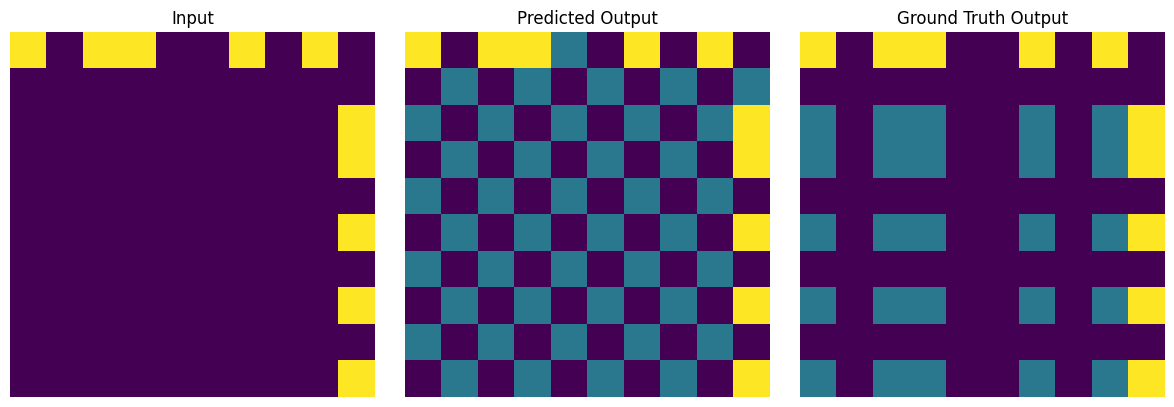

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Your test case
test_case = {
    "input": [
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
    ],
    "output": [
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5]
    ]
}

# Apply your transform function
predicted_output = transform(test_case["input"])

# Plot the grids
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

titles = ["Input", "Predicted Output", "Ground Truth Output"]
grids = [test_case["input"], predicted_output, test_case["output"]]

for ax, grid, title in zip(axs, grids, titles):
    im = ax.imshow(grid, cmap="viridis", vmin=0, vmax=5)
    ax.set_title(title)
    ax.axis("off")

# fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()


In [24]:
# stop

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [25]:
# !pip show transformers

In [26]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/chat_template.jinja',
 'lora_model/vocab.json',
 'lora_model/merges.txt',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [27]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        load_in_4bit = True,
    )

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [28]:
from huggingface_hub import HfFolder, login

# Call this at the top of your script / notebook
if HfFolder.get_token() is None:   # no token cached or in $HF_TOKEN
    login()                        # interactive prompt

In [29]:
# print(model)

In [30]:
print(f"Pushing to Trelis/{run_name}")

Pushing to Trelis/qwen_gemini_synth_10-23jul


In [31]:
model = model.merge_and_unload()
model.push_to_hub(f"Trelis/{run_name}")
tokenizer.push_to_hub(f"Trelis/{run_name}")

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Saved model to https://huggingface.co/Trelis/qwen_gemini_synth_10-23jul


No files have been modified since last commit. Skipping to prevent empty commit.


In [32]:
# # Merge to 16bit
# if False:
#     model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
# if True: # Pushing to HF Hub
#     model.push_to_hub_merged(f"Trelis/{run_name}", tokenizer, save_method = "merged_16bit")

# # Merge to 4bit
# if False:
#     model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
# if False: # Pushing to HF Hub
#     model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# # Just LoRA adapters
# if False:
#     model.save_pretrained("model")
#     tokenizer.save_pretrained("model")
# if False: # Pushing to HF Hub
#     model.push_to_hub("hf/model", token = "")
#     tokenizer.push_to_hub("hf/model", token = "")


In [33]:
# print(tokenizer.chat_template)

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [34]:
# Save to 8bit Q8_0
if False:
    model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False:
    model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
